# About This Notebook

# Efficient Deep Active Learning (EDAL)

**In this notebook we will do several experiments related to the problem for efficient Active Learning. More precicely, we will consider Resenbrock2D problem. As for acquisition function, we take Maximum Variance. For now, we will just use Gpytorch library, that provide us powefull and commputationally efficeint implementation of Gaussian Processes on Pytorch. We compare simple GP and GP with Neural Network. For predictive purposes, we will use LOVE method.**

<img src="EDAL.jpg">

In [1]:
from matplotlib import image
from matplotlib.pyplot import imread
from IPython import display

import os
import time
import math
from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.optimize import rosen

# Visualization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
import plotly.graph_objs as go

# To plot in offline 
plotly.offline.init_notebook_mode(connected=True)


# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import gpytorch
torch.random.manual_seed(123456)

# Generating Data

In [2]:
np.random.seed(123)

num_train_points = 1000
num_test_points = 100
num_dims = 2

X = np.random.random((num_train_points, num_dims))
#y = rosen(X.T).reshape(-1, 1)
y = rosen(X.T)

X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size = 0.9)


X_test = np.random.random((num_test_points, num_dims))
y_test = rosen(X_test.T)

X_train.shape, y_train.shape, X_pool.shape, y_pool.shape, X_test.shape, y_test.shape

((100, 2), (100,), (900, 2), (900,), (100, 2), (100,))

In [3]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_pool = torch.Tensor(X_pool)
y_pool = torch.Tensor(y_pool)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

X_train.shape, y_train.shape, X_pool.shape, y_pool.shape, X_test.shape, y_test.shape

(torch.Size([100, 2]),
 torch.Size([100]),
 torch.Size([900, 2]),
 torch.Size([900]),
 torch.Size([100, 2]),
 torch.Size([100]))

# Required Functions for model and training

In [4]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel()
            )
            
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
def train(gp_model, opt, mll_loss, train_X, train_y):
    
    for i in range(training_iterations):
        
        opt.zero_grad()
        output = gp_model(train_X)
        loss = -mll_loss(output, train_y)
        loss.backward()
        opt.step()    
        
        # Then we print the results for this epoch:
        print('Iter %d/%d -MLL Loss: %.3f' % (i + 1, training_iterations, loss.item()))

In [6]:
def Max_Variance_Query_Function(model, likelihood, pool_X, q_batch, mode):
    
    # Set into eval mode
    model.eval()
    likelihood.eval()
    
    if mode == 'simple':
        with torch.no_grad():
            start_time = time.time()
            preds = model(pool_X)
            exact_covar = preds.covariance_matrix
            exact_covar_time = time.time() - start_time
        return torch.sort(torch.diag(exact_covar), descending=True)[1][:q_batch], exact_covar_time   
    
    elif mode == 'fast':
        with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(500):
            start_time = time.time()
            preds = model(pool_x)
            fast_covar = preds.covariance_matrix
            fast_covar_time_without_cashe = time.time() - start_time
        
        return torch.sort(torch.diag(fast_covar), descending=True)[1][:q_batch], fast_covar_time_without_cashe
    
    else:
        raise Exception("Check mode: simple or fast only")

# Experiment 1:

**In this experiment, we compare time of evaluation of covariance matrix for Test set using two approaches: without and with LOVE. We will use implemented in Gpytorch models, based on "Constant-Time Predictions for GP" article.:**

In [7]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(X_train, y_train, likelihood)

In [8]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 20

In [9]:
%time train(model, optimizer, mll, X_train, y_train)

Iter 1/20 -MLL Loss: 138.818
Iter 2/20 -MLL Loss: 118.718
Iter 3/20 -MLL Loss: 101.409
Iter 4/20 -MLL Loss: 86.778
Iter 5/20 -MLL Loss: 74.664
Iter 6/20 -MLL Loss: 64.822
Iter 7/20 -MLL Loss: 57.009
Iter 8/20 -MLL Loss: 50.895
Iter 9/20 -MLL Loss: 46.182
Iter 10/20 -MLL Loss: 42.559
Iter 11/20 -MLL Loss: 39.751
Iter 12/20 -MLL Loss: 37.552
Iter 13/20 -MLL Loss: 35.771
Iter 14/20 -MLL Loss: 34.314
Iter 15/20 -MLL Loss: 33.093
Iter 16/20 -MLL Loss: 32.043
Iter 17/20 -MLL Loss: 31.149
Iter 18/20 -MLL Loss: 30.322
Iter 19/20 -MLL Loss: 29.581
Iter 20/20 -MLL Loss: 28.909
CPU times: user 837 ms, sys: 12.6 ms, total: 850 ms
Wall time: 321 ms


In [10]:
# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    start_time = time.time()
    preds = model(X_pool)
    exact_covar = preds.covariance_matrix
    exact_covar_time = time.time() - start_time

In [11]:
print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))

Time to compute exact mean + covariances: 0.11s


In [12]:
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(25):
    start_time = time.time()
    preds = model(X_pool)
    fast_covar = preds.covariance_matrix
    fast_time_with_cache = time.time() - start_time

In [13]:
print('Time to compute mean + covariances (with cache) {:.2f}s'.format(fast_time_with_cache))

Time to compute mean + covariances (with cache) 0.08s


In [14]:
print('MAE between exact covar matrix and fast covar matrix: {}'.format((exact_covar - fast_covar).abs().mean()))

MAE between exact covar matrix and fast covar matrix: 0.0009841733844950795


# Conclusion:

**As we can see, predictions with LOVE needed less time for computing them with a big MAE accuracy. And this compational gap will significantly increase with dimensionality and number of training points.**

# Experiment 2

# Active Learning withn Maximum Variance Query Strategy

In [15]:
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)

X_pool_copy = deepcopy(X_pool)
y_pool_copy = deepcopy(y_pool)

X_test_copy = deepcopy(X_test)
y_test_copy = deepcopy(y_test)

In [16]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(X_train_copy, y_train_copy, likelihood)

In [17]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 20

In [18]:
%time train(model, optimizer, mll, X_train_copy, y_train_copy)

Iter 1/20 -MLL Loss: 138.820
Iter 2/20 -MLL Loss: 118.718
Iter 3/20 -MLL Loss: 101.405
Iter 4/20 -MLL Loss: 86.778
Iter 5/20 -MLL Loss: 74.656
Iter 6/20 -MLL Loss: 64.830
Iter 7/20 -MLL Loss: 57.018
Iter 8/20 -MLL Loss: 50.894
Iter 9/20 -MLL Loss: 46.180
Iter 10/20 -MLL Loss: 42.556
Iter 11/20 -MLL Loss: 39.735
Iter 12/20 -MLL Loss: 37.549
Iter 13/20 -MLL Loss: 35.778
Iter 14/20 -MLL Loss: 34.323
Iter 15/20 -MLL Loss: 33.106
Iter 16/20 -MLL Loss: 32.054
Iter 17/20 -MLL Loss: 31.151
Iter 18/20 -MLL Loss: 30.332
Iter 19/20 -MLL Loss: 29.589
Iter 20/20 -MLL Loss: 28.884
CPU times: user 837 ms, sys: 8.67 ms, total: 846 ms
Wall time: 319 ms


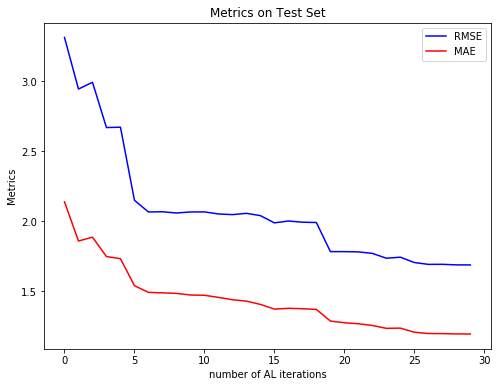

Epoch 30 of 30 took 1.389s
RMSE metrics: 	1.688533
MAE megrics: 	1.196009


In [19]:
budget = 30
q_batch = 5
mode = 'simple'
training_iterations = 60

times = []
rmse_metrics = []
mae_metrics = []

for budget_iter in range(0, budget):    
    
    al_start_time = time.time()
    
    if len(X_pool_copy) == 0:
        break
    
    # Get query points
    if q_batch < len(X_pool_copy):
        query_points, query_time = Max_Variance_Query_Function(model, likelihood, X_pool_copy, 
                                                               q_batch, mode)
    
    else:
        ##TO DO 
        # Add the right time
        ##
        query_points, query_time = torch.arange(0, len(X_pool_copy)), times[-1]

    
    times.append(query_time)
    
    # Add query_points to Train set
    X_train_copy = torch.cat((X_train_copy, X_pool_copy[query_points]), 0)
    y_train_copy = torch.cat((y_train_copy, y_pool_copy[query_points]), 0)
    
    # Delete points from Query Set
    # Is any opportunity to do it in anothe way?        
    mask = torch.ones(len(X_pool_copy), dtype=torch.uint8)
    mask[query_points] = 0
    X_pool_copy = X_pool_copy[mask, ...]
    y_pool_copy = y_pool_copy[mask]
    
    # Creating model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(X_train_copy, y_train_copy, likelihood)
    
    # Training
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer 
    # Includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    train(model, optimizer, mll, X_train_copy, y_train_copy)
    
    # Calculate Covariance for test points using simple SKI
    
    # Set into eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        preds = model(X_test_copy)
        
    # calculate metrics
    rmse = torch.sqrt(torch.mean(torch.pow(preds.mean - y_test, 2)))
    rmse_metrics.append(rmse)
    
    
    mae = torch.mean(torch.abs(preds.mean - y_test))
    mae_metrics.append(mae)
    
    print('Test RMSE: {}'.format(rmse))
    print('Test MAE: {}'.format(mae))
    
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Metrics on Test Set")
    plt.xlabel("number of AL iterations")
    plt.ylabel("Metrics")
    #plt.yscale('log')
    plt.plot(rmse_metrics, 'b', label = "RMSE")
    plt.plot(mae_metrics, 'r', label = "MAE")
    plt.legend()
    plt.show()

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(budget_iter + 1, 
            np.minimum(math.ceil(len(X_pool) / q_batch), budget), 
            time.time() - al_start_time))
    print("RMSE metrics: \t{:.6f}".format(rmse_metrics[-1]))
    print("MAE megrics: \t{:.6f}".format(mae_metrics[-1]))
    
    # Save
    #torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')
    #np.save("train_loss_per_epoch", train_loss_per_epoch)
    #np.save("val_loss_per_epoch", val_loss_per_epoch)

In [20]:
MV_rmse_metrics = deepcopy(rmse_metrics)
MV_mae_metrics = deepcopy(mae_metrics)
MV_times = deepcopy(times)

# Active Learning withn Random Sampling Query Strategy

In [21]:
X_train_copy = deepcopy(X_train)
y_train_copy = deepcopy(y_train)

X_pool_copy = deepcopy(X_pool)
y_pool_copy = deepcopy(y_pool)

X_test_copy = deepcopy(X_test)
y_test_copy = deepcopy(y_test)

In [22]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(X_train_copy, y_train_copy, likelihood)

In [23]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 20

In [24]:
%time train(model, optimizer, mll, X_train_copy, y_train_copy)

Iter 1/20 -MLL Loss: 138.817
Iter 2/20 -MLL Loss: 118.719
Iter 3/20 -MLL Loss: 101.413
Iter 4/20 -MLL Loss: 86.777
Iter 5/20 -MLL Loss: 74.660
Iter 6/20 -MLL Loss: 64.824
Iter 7/20 -MLL Loss: 57.004
Iter 8/20 -MLL Loss: 50.896
Iter 9/20 -MLL Loss: 46.190
Iter 10/20 -MLL Loss: 42.549
Iter 11/20 -MLL Loss: 39.746
Iter 12/20 -MLL Loss: 37.536
Iter 13/20 -MLL Loss: 35.773
Iter 14/20 -MLL Loss: 34.334
Iter 15/20 -MLL Loss: 33.112
Iter 16/20 -MLL Loss: 32.068
Iter 17/20 -MLL Loss: 31.160
Iter 18/20 -MLL Loss: 30.316
Iter 19/20 -MLL Loss: 29.589
Iter 20/20 -MLL Loss: 28.913
CPU times: user 807 ms, sys: 8.3 ms, total: 815 ms
Wall time: 308 ms


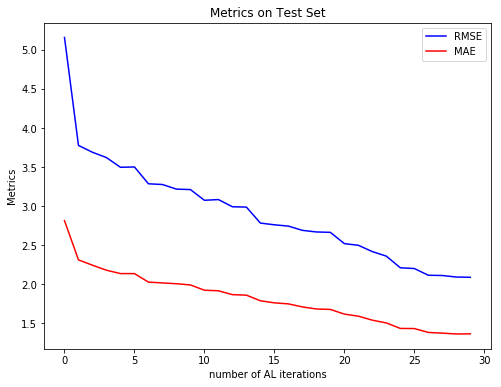

Epoch 30 of 30 took 1.318s
RMSE metrics: 	2.087131
MAE megrics: 	1.363019


In [25]:
budget = 30
q_batch = 5
training_iterations = 60

times = []
rmse_metrics = []
mae_metrics = []

for budget_iter in range(0, budget):    
    
    al_start_time = time.time()
    
    if len(X_pool_copy) == 0:
        break
    
    # Get query points
    if q_batch < len(X_pool_copy):
        query_points = torch.randperm(len(X_pool_copy))[:q_batch]
    
    else:
        ##TO DO 
        # Add the right time
        ##
        query_points, query_time = torch.arange(0, len(X_pool_copy)), times[-1]

    
    times.append(query_time)
    
    # Add query_points to Train set
    X_train_copy = torch.cat((X_train_copy, X_pool_copy[query_points]), 0)
    y_train_copy = torch.cat((y_train_copy, y_pool_copy[query_points]), 0)
    
    # Delete points from Query Set
    # Is any opportunity to do it in anothe way?        
    mask = torch.ones(len(X_pool_copy), dtype=torch.uint8)
    mask[query_points] = 0
    X_pool_copy = X_pool_copy[mask, ...]
    y_pool_copy = y_pool_copy[mask]
    
    # Creating model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRegressionModel(X_train_copy, y_train_copy, likelihood)
    
    # Training
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer 
    # Includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    train(model, optimizer, mll, X_train_copy, y_train_copy)
    
    # Calculate Covariance for test points using simple SKI
    
    # Set into eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        preds = model(X_test_copy)
        
    # calculate metrics
    rmse = torch.sqrt(torch.mean(torch.pow(preds.mean - y_test, 2)))
    rmse_metrics.append(rmse)
    
    
    mae = torch.mean(torch.abs(preds.mean - y_test))
    mae_metrics.append(mae)
    
    print('Test RMSE: {}'.format(rmse))
    print('Test MAE: {}'.format(mae))
    
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Metrics on Test Set")
    plt.xlabel("number of AL iterations")
    plt.ylabel("Metrics")
    #plt.yscale('log')
    plt.plot(rmse_metrics, 'b', label = "RMSE")
    plt.plot(mae_metrics, 'r', label = "MAE")
    plt.legend()
    plt.show()

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(budget_iter + 1, 
            np.minimum(math.ceil(len(X_pool) / q_batch), budget), 
            time.time() - al_start_time))
    print("RMSE metrics: \t{:.6f}".format(rmse_metrics[-1]))
    print("MAE megrics: \t{:.6f}".format(mae_metrics[-1]))
    
    # Save
    #torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')
    #np.save("train_loss_per_epoch", train_loss_per_epoch)
    #np.save("val_loss_per_epoch", val_loss_per_epoch)

In [26]:
RS_rmse_metrics = deepcopy(rmse_metrics)
RS_mae_metrics = deepcopy(mae_metrics)
RS_times = deepcopy(times)

# Plotting and Comparison

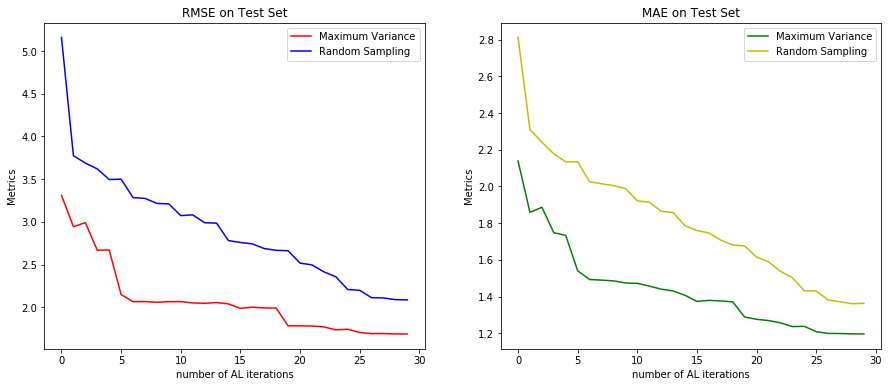

In [27]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)

ax1.plot(MV_rmse_metrics, 'r', label = "Maximum Variance")
ax1.plot(RS_rmse_metrics, 'b', label = "Random Sampling")

ax1.set_xlabel("number of AL iterations")
ax1.set_ylabel("Metrics")
ax1.set_title("RMSE on Test Set")
ax1.legend()

############################################
ax2 = fig.add_subplot(122)

ax2.plot(MV_mae_metrics, 'g', label = "Maximum Variance")
ax2.plot(RS_mae_metrics, 'y', label = "Random Sampling")

ax2.set_xlabel("number of AL iterations")
ax2.set_ylabel("Metrics")
ax2.set_title("MAE on Test Set")
ax2.legend()

plt.show()

# Conclusion

**As we may see, using Maximum Variance Query Strategy allow us to obtain significantly better convergence on this task.**